In [1]:
!pip install simpy

###Новые потоки и реальные данные

In [48]:
import simpy
import matplotlib.pyplot as plt
import numpy as np
import random


max_time = 100.0

mu_ = [[100, 10, 1], [100, 10, 1], [50, 5, 0.5], [20, 2, 0.2], [200, 10, 1], [50, 5, 0.5], [20, 2, 0.2]]

lambda_ = [100, 50, 50, 200, 200, 100, 50]

capacities = [100000, 150000, 200000]

color_list = ['#5B9BD5', '#ED7D31', '#70AD47']

densities = [50, 15, 10, 20, 0.5, 1, 0.5]

server_weights = [[0.6, 0.3, 0.1],
                  [0.3, 0.5, 0.2],
                  [0.4, 0.3, 0.3],
                  [0.4, 0.3, 0.3],
                  [0.6, 0.3, 0.1],
                  [0.4, 0.3, 0.3],
                  [0.6, 0.3, 0.1]]

routing_matrices = [[[0.7, 0.2, 0.1],
                  [0.2, 0.5, 0.3],
                  [0.1, 0.4, 0.5]],

                 [[0.7, 0.2, 0.1],
                  [0.2, 0.5, 0.3],
                  [0.1, 0.4, 0.5]],

                 [[0.6, 0.3, 0.1],
                  [0.3, 0.4, 0.3],
                  [0.1, 0.3, 0.6]],

                 [[0.6, 0.3, 0.1],
                  [0.3, 0.4, 0.3],
                  [0.1, 0.3, 0.6]],

                 [[0.7, 0.2, 0.1],
                  [0.2, 0.5, 0.3],
                  [0.1, 0.4, 0.5]],

                 [[0.6, 0.3, 0.1],
                  [0.3, 0.4, 0.3],
                  [0.1, 0.4, 0.5]],

                 [[0.7, 0.2, 0.1],
                  [0.3, 0.4, 0.3],
                  [0.2, 0.3, 0.5]]]

class Server:
    def __init__(self, env, id, capacity, color):
        self.env = env
        self.id = id
        self.color = color
        self.resource = simpy.Resource(env, capacity=capacity)
        self.moving_average = {}
        self.number_of_task = {}

    def process_request(self, stream):
        with self.resource.request() as req:
            yield req
            self.number_of_task[self.env.now] = self.resource.count
            self.moving_average[self.env.now] = sum(self.number_of_task.values()) / len(self.number_of_task.values())
            #service_time = np.random.exponential(scale=1/stream.mu[self.id])
            service_time = random.expovariate(stream.mu[self.id])
            yield self.env.timeout(service_time)
            self.number_of_task[self.env.now] = self.resource.count
            self.moving_average[self.env.now] = sum(self.number_of_task.values()) / len(self.number_of_task.values())

            next_server = stream.server_choice(stream.routing_matrix[self.id])
            if(next_server != self.id):
              self.env.process(stream.servers[next_server].process_request(stream))


class Stream:
    def __init__(self, env, id, lambda_, mu, server_weights, densities, routing_matrix, servers):
        self.env = env
        self.id = id
        self.lambda_ = lambda_
        self.mu = mu
        self.server_weights = server_weights
        self.densities = densities
        self.routing_matrix = routing_matrix
        self.servers = servers

    def generate_request(self):
      while True:
        #inter_arrival_time = np.random.exponential(scale=1/self.lambda_)
        inter_arrival_time = random.expovariate(self.lambda_)
        yield self.env.timeout(inter_arrival_time)
        server_id = self.server_choice(self.server_weights)
        self.env.process(self.servers[server_id].process_request(self))

    def server_choice(self, probabilities):
        return np.random.choice(3, p=probabilities)


def run_simulation(max_time, mu_, lambda_, capacities, color_list, densities, server_weights, routing_matrices):
    env = simpy.Environment()
    servers = []
    streams = []

    for i, capacity in enumerate(capacities):
        server = Server(env, i, capacity, color_list[i])
        servers.append(server)

    for i, stream_lambda in enumerate(lambda_):
        stream = Stream(env, i, stream_lambda, mu_[i], server_weights[i], densities[i], routing_matrices[i], servers)
        streams.append(stream)
        env.process(stream.generate_request())

    env.run(until=max_time)
    print('All done!')
    return env, servers

In [49]:
env, servers = run_simulation(max_time, mu_, lambda_, capacities, color_list, densities, server_weights, routing_matrices)

All done!


In [50]:
def plot_results(server, max_time):
    plt.plot(list(server.number_of_task.keys()), list(server.number_of_task.values()), label='Случайный процесс', color=server.color, alpha=0.5)
    plt.plot(list(server.moving_average.keys()), list(server.moving_average.values()), label='Скользящее среднее', color=server.color)
    plt.xlim(0, max_time)
    plt.ylim(0, 350)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlabel('Время')
    plt.ylabel('Количество заявок')
    plt.legend(loc=1)
    plt.show()

    plt.hist(list(server.number_of_task.values()), density=True, bins=np.linspace(0, 350, 50), color=server.color, alpha=0.5)
    plt.axvline((np.mean(list(server.number_of_task.values()))), color=server.color, linestyle='-', linewidth=1, label='Эмпирическое среднее')
    plt.xlim(0, 350)
    plt.ylim(0, 0.05)
    plt.xlabel('Количество заявок')
    plt.ylabel('Вероятность')
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.show()

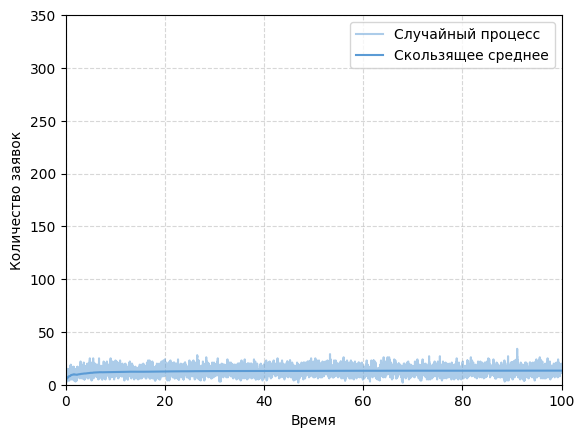

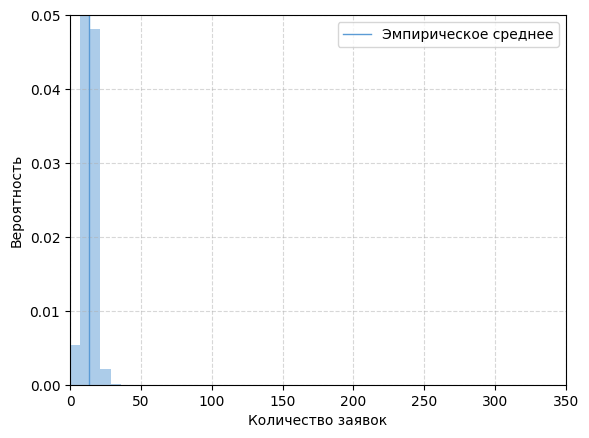

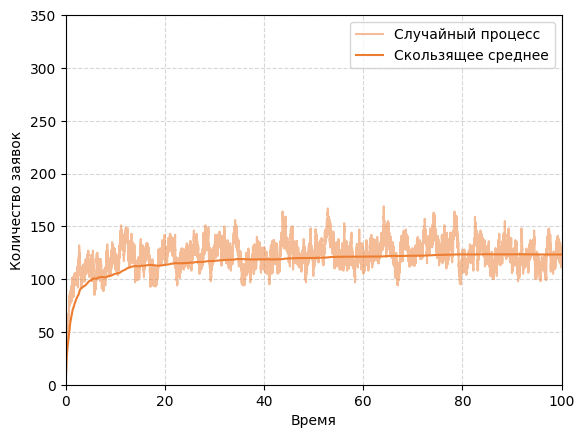

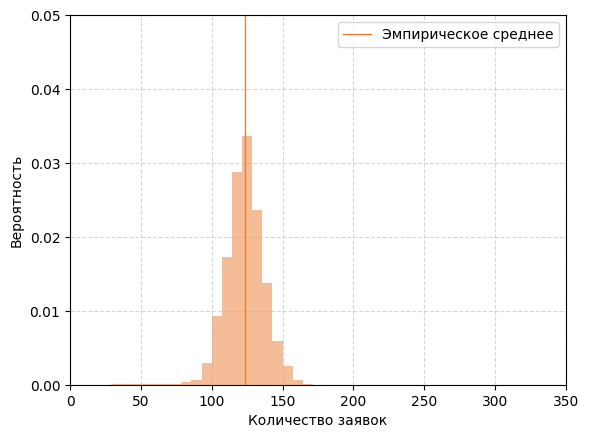

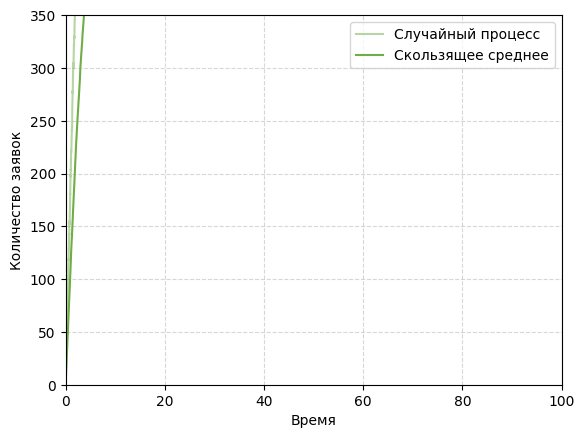

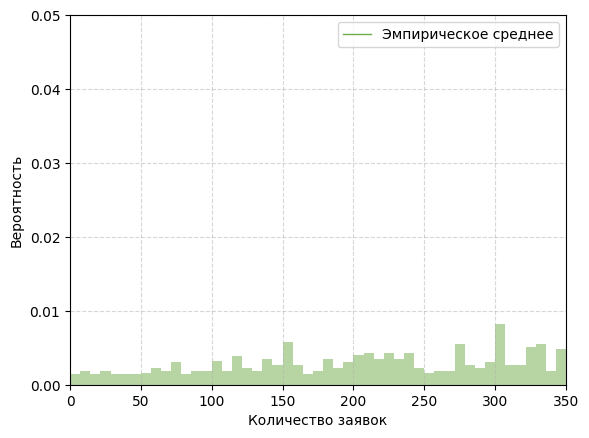

In [51]:
for i, server in enumerate(servers):
    plot_results(server, max_time)